# The preceeding ipynb is semi more general in selecting it's blurring region.
# It is capable of selecting cuboid, i.e. unequal sides
# This ipynb restricts to only cubes, i.e. equal sides, as an attempt to be more computationally efficient
# The reason for this restriction relies on the assumption that the blurring region are spheres

## Importing Libraries

In [286]:
%matplotlib inline
import matplotlib.pyplot as plt
import logging
import numpy as np
import py21cmfast as p21c
import caffeine

## Cosmological Parameters (Default is used when no input is specified)

In [6]:
cosmo_params = p21c.CosmoParams()

## User Parameters, like box length, number of voxels (i.e. resolution) etc.

In [7]:
user_params = p21c.UserParams(
    BOX_LEN=301,  # Box length
    DIM=2*301,      # Number of Voxels for hight resolution 
    HII_DIM=301  # Number of Voxels for low resolution 
)

## Creating initial conditions box

In [8]:
init_cond = p21c.initial_conditions(
    cosmo_params=cosmo_params,
    user_params=user_params
)

## Gaussian function

In [9]:
def Gaussian(x, sigma):  # μ=0, σ=1/sqrt(2), π=1
    Gaussian = np.exp(-(x/sigma)**2)
    return Gaussian

## Measure the distance of each voxel to the center

In [26]:
def distance_from_coordinate(box_length):
        
    index = np.arange(-0.5*(box_length-1), 0.5*(box_length+1))

    x_mesh, y_mesh, z_mesh = np.meshgrid(index, index, index, indexing='ij')
    
    distance = np.sqrt((x_mesh)**2 + (y_mesh)**2 + (z_mesh)**2)
    
    return distance

## Random Coordinate

In [304]:
def random_voxel(box_length):
    
#     np.random.seed()  # set seed to a randome number
    np.random.seed(4) ; np.random.rand(10)  # specifying seed for testing purposes

    coordinate = np.random.randint(0, box_length, size=3)

    return coordinate

## Select a Smaller Cube with Sides 2R+1 Voxels, Centered about the Random Coordinate

In [12]:
def cube_centered_about_coordinate(coordinate_array, radius, box):
    x_ind1 = coordinate_array[0]-radius  # x-domian
    x_ind2 = coordinate_array[0]+radius+1  # ending index is not inclusive
    y_ind1 = coordinate_array[1]-radius  # y-domain
    y_ind2 = coordinate_array[1]+radius+1
    z_ind1 = coordinate_array[2]-radius  # z-domain
    z_ind2 = coordinate_array[2]+radius+1

    if x_ind1 < 0:  # periodic boundary conditions
        x_inds = np.r_[(x_ind1+len(box)):len(box), 0:x_ind2]
    elif x_ind2 > len(box):
        x_inds = np.r_[x_ind1:len(box), 0:(x_ind2-len(box))]
    else:
        x_inds = np.r_[x_ind1:x_ind2]

    if y_ind1 < 0:
        y_inds = np.r_[(y_ind1+len(box)):len(box), 0:y_ind2]
    elif y_ind2 > len(box):
        y_inds = np.r_[y_ind1:len(box), 0:(y_ind2-len(box))]
    else:
        y_inds = np.r_[y_ind1:y_ind2]

    if z_ind1 < 0:
        z_inds = np.r_[(z_ind1+len(box)):len(box), 0:z_ind2]
    elif z_ind2 > len(box):
        z_inds = np.r_[z_ind1:len(box), 0:(z_ind2-len(box))]
    else:
        z_inds = np.r_[z_ind1:z_ind2]

    indices = np.ix_(x_inds, y_inds, z_inds)
        
    output_box = box[indices]
    
    return output_box

## Gausssian Sphere Averaging

In [13]:
def gaussian_sphere_average(distance_box, radius, input_box, shell_num, sigma_factor):
    
    mean = []

    shell_radius_edges = np.linspace(0,1,shell_num+1)
    shell_center = 0.5*(shell_radius_edges[1:] + shell_radius_edges[:-1])*sigma_factor*radius  
    # sigma_factor number of sigmas the weighting goes out to, sigma = radius
    weight = Gaussian(x=shell_center, sigma=radius)

    for ii in range(shell_num):
        condition = np.logical_and(
            distance_box <= shell_radius_edges[ii+1]*radius, 
            distance_box > shell_radius_edges[ii]*radius
        )
        inside_shell_mean = np.mean(input_box[condition])
        mean = np.append(mean, inside_shell_mean)
        
    Gaussian_mean = np.average(mean, weights=weight)
    
    return Gaussian_mean

## Top Hat Sphere Averaging

In [14]:
def top_hat_sphere_average(distance_box, radius, input_box):
    
    condition = distance_box <= radius
    mean = np.mean(input_box[condition])
    
    return mean

## Top Hat Cube Averaging

In [15]:
def top_hat_cube_average(input_box):
    
    mean = np.mean(input_box)
    
    return mean

## Sphere Blurring Function

In [16]:
def Average_Neutral_Fraction_Distribution(
    box, 
    radius, 
    iteration, 
    shell_num=6, 
    sigma_factor=4, 
    blur_shape=None
):
    
    box = box.copy()  # make copy of input box to have a separate box
    
    mean_data = []  # empty list for data collection
    
    if blur_shape == 'Gaussian_sphere':
        dist_frm_coord_box = distance_from_coordinate(radius*2+1)
        for i in range(iteration):
            rand_coord = random_voxel(len(box))
            cube_region_box = cube_centered_about_coordinate(rand_coord, radius, box)
            mean = gaussian_sphere_average(dist_frm_coord_box, radius, cube_region_box, shell_num, sigma_factor)
            mean_data = np.append(mean_data, mean)
        
    elif blur_shape == 'top_hat_sphere':
        radius = int(round(radius*((3*np.sqrt(np.pi)/4)**(1/3))))  # ratio numerically calculated.
        dist_frm_coord_box = distance_from_coordinate(radius*2+1)
        for i in range(iteration):
            rand_coord = random_voxel(len(box))
            cube_region_box = cube_centered_about_coordinate(rand_coord, radius, box)
            mean = top_hat_sphere_average(dist_frm_coord_box, radius, cube_region_box)
            mean_data = np.append(mean_data, mean)
            
    elif blur_shape == 'top_hat_cube':
        radius = int(round((radius*np.sqrt(np.pi)-1)/2))  # ratio determiend by equating the volumes of cube & sphere
        for i in range(iteration):
            rand_coord = random_voxel(len(box))
            cube_region_box = cube_centered_about_coordinate(rand_coord, radius, box)
            mean = top_hat_cube_average(cube_region_box)
            mean_data = np.append(mean_data, mean)
    else:
        print('Blurring shape assumed to be a Gaussian sphere with 4 shells \
              weighted by equally spaced values from 0 sigma to 4 sigma.')
        dist_frm_coord_box = distance_from_coordinate(radius*2+1)
        for i in range(iteration):
            rand_coord = random_voxel(len(box))
            cube_region_box = cube_centered_about_coordinate(rand_coord, radius, box)
            mean = gaussian_sphere_average(dist_frm_coord_box, radius, cube_region_box, shell_num, sigma_factor)
            mean_data = np.append(mean_data, mean)
            
    return mean_data

## Histogram Function

In [303]:
def histogram(
    fs, 
    figure_shape, 
    title=None, 
    x_start=0, 
    x_stop=1, 
    bin_num=100, 
    color='white', 
    figure_size=(18,7), 
    font_size=15, 
    horizontal_gap=0.05, 
    vertical_gap=0.05, 
    y_scale='linear', 
    y_notation='plain', 
    sharex=True, 
    sharey=True
):  # a: x start, b: x stop
    
    bin_edges = np.linspace(x_start, x_stop, bin_num) # 100 bins from 0-1
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    if type(fs) is tuple:  # hopefully more robust condition.
        fig, axes = plt.subplots(
            figure_shape[0], 
            figure_shape[1], 
            figsize=figure_size, 
            sharex=sharex, 
            sharey=sharey, 
            gridspec_kw={"hspace":vertical_gap, 'wspace':horizontal_gap})
        for i, f in enumerate(fs):
            axes.flatten()[i].plot(bin_centers, np.histogram(f, bins=bin_edges)[0])
            if title is not None:
                axes.flatten()[i].set_title(title[i], color=color, fontsize=font_size)
            axes.flatten()[i].tick_params(color=color, labelcolor=color, labelsize=font_size)  # figure color
            axes.flatten()[i].set_yscale(y_scale)
            if y_notation is 'sci':
                axes.flatten()[i].ticklabel_format(axis='y', style=y_notation, scilimits=(0,0), useMathText=True)
            for spine in axes.flatten()[i].spines.values():
                spine.set_edgecolor(color)
    else:
        fig, ax = plt.subplots(figsize=figure_size)
        ax.plot(bin_centers, np.histogram(fs, bins=bin_edges)[0])
        if title is not None:
            ax.set_title(title, color=color, fontsize=font_size)
        ax.tick_params(color=color, labelcolor=color, labelsize=font_size)  # figure color
        ax.set_yscale(y_scale)
        if y_notation is 'sci':
            ax.ticklabel_format(axis='y', style=y_notation, scilimits=(0,0), useMathText=True)
        for spine in ax.spines.values():
            spine.set_edgecolor(color)

## Plots

In [301]:
def plots(
    x_vals, 
    y1s, 
    figure_shape, 
    y2s=None, 
    y3s=None, 
    y4s=None,
    y5s=None,
    y6s=None,
    y7s=None,
    y1s_label=None, 
    y2s_label=None, 
    y3s_label=None,
    y4s_label=None,
    y5s_label=None,
    y6s_label=None,
    y7s_label=None,
    title=None,
    shared_title=None,
    shared_title_x_position=0.5,   # figure coordinates, max=1 I think
    shared_title_y_position=0.92,
    x_shared_label=None, 
    x_shared_label_x_position=0.5,
    x_shared_label_y_position=0.08,
    y_shared_label=None, 
    y_shared_label_x_position=0.07,
    y_shared_label_y_postion=0.5,
    y_label=None, 
    color='white', 
    figure_size=(18,7), 
    font_size=15, 
    horizontal_gap=0.05, 
    vertical_gap=0.05, 
    y_scale='linear', 
    y_notation='plain', 
    sharex=True, 
    sharey=True
):  # a: x start, b: x stop
    
    if type(y1s) is tuple:  # hopefully more robust condition.
        
        fig, axes = plt.subplots(
            figure_shape[0], 
            figure_shape[1], 
            figsize=figure_size, 
            sharex=sharex, 
            sharey=sharey, 
            gridspec_kw={"hspace":vertical_gap, 'wspace':horizontal_gap}
        )
        
        if shared_title is not None:
            fig.suptitle(
                x=shared_title_x_position, 
                y=shared_title_y_position, 
                t=shared_title, ha='center', 
                size=1.5*font_size, 
                color=color
            )
        
        for i, y1 in enumerate(y1s):
            
            axes.flatten()[i].plot(x_vals, y1, label=y1s_label)  # plotting f
            
            if y2s is not None:  # plotting g if iterable is inputted
                axes.flatten()[i].plot(x_vals, y2s[i], '--', label=y2s_label)
                
                if y3s is None:
                    axes.flatten()[i].legend()
                    
                else:  # plotting h if iterable is inputted
                    axes.flatten()[i].plot(x_vals, y3s[i], '-.', label=y3s_label)
                    
                    if y4s is None:
                        axes.flatten()[i].legend()
                        
                    else:
                        axes.flatten()[i].plot(x_vals, y4s[i], ':', label=y4s_label)
                        
                        if y5s is None:
                            axes.flatten()[i].legend()
                            
                        else:
                            axes.flatten()[i].plot(x_vals, y5s[i], '-o', label=y5s_label)
                            
                            if y6s is None:
                                axes.flatten()[i].legend()
                            
                            else:
                                axes.flatten()[i].plot(x_vals, y6s[i], '-*', label=y6s_label)
                                
                                if y7s is None:
                                    axes.flatten()[i].legend()
                            
                                else:
                                    axes.flatten()[i].plot(x_vals, y7s[i], '-x', label=y7s_label)
                                    axes.flatten()[i].legend()
            
            if title is not None:  # title if inputted
                axes.flatten()[i].set_title(title[i], color=color, fontsize=font_size)
            
            if y_label is not None:  # y label if inputted
                axes.flatten()[i].set_ylabel(y_label[i], color=color, fontsize=font_size)
                
            if x_shared_label is not None:  # shared x label
                fig.text(
                    x=x_shared_label_x_position, 
                    y=x_shared_label_y_position, 
                    s=x_shared_label, ha='center', 
                    size=font_size, 
                    color=color
                )
            
            if y_shared_label is not None:  # shared y label
                fig.text(
                    x=y_shared_label_x_position, 
                    y=y_shared_label_y_postion, 
                    s=y_shared_label, 
                    va='center', 
                    rotation='vertical', 
                    size=font_size, 
                    color=color
                )
            
            axes.flatten()[i].set_yscale(y_scale)  # y axis linear or log scale
            
            if y_notation is 'sci':  # plain or scientific notation
                axes.flatten()[i].ticklabel_format(
                    axis='y', 
                    style=y_notation[i], 
                    scilimits=(0,0), 
                    useMathText=True
                )
            
            axes.flatten()[i].tick_params(
                color=color, 
                labelcolor=color, 
                labelsize=font_size, 
                size=font_size
            )  # font style
            
            for spine in axes.flatten()[i].spines.values():  # figure spine color
                spine.set_edgecolor(color)

    else:
        
        fig, ax = plt.subplots(figsize=figure_size)  # creating subplots
        
        ax.plot(x_vals, y1s, label=y1s_label)  # plotting f
        
        if y2s is not None:  # plotting g if inputted
            ax.plot(x_vals, y2s, '--', label=y2s_label)
            
            if y3s is None:
                ax.legend()

            else:  # plotting h if iterable is inputted
                ax.plot(x_vals, y3s, '-.', label=y3s_label)

                if y4s is None:
                    ax.legend()

                else:
                    ax.plot(x_vals, y4s, ':', label=y4s_label)

                    if y5s is None:
                        ax.legend()

                    else:
                        ax.plot(x_vals, y5s, '-o', label=y5s_label)

                        if y6s is None:
                            ax.legend()

                        else:
                            ax.plot(x_vals, y6s, '-*', label=y6s_label)

                            if y7s is None:
                                ax.legend()

                            else:
                                ax.plot(x_vals, y7s, '-x', label=y7s_label)
                                ax.legend()
            
        if title is not None:  # title if inputed
            ax.set_title(title, color=color, fontsize=font_size)
            
        if y_label is not None:  # y label  if inputed
            ax.set_ylabel(y_label, color=color, fontsize=font_size)
            
        ax.set_yscale(y_scale)  # linear or log
        
        if y_notation is 'sci':  # plain or scientific notation
            ax.ticklabel_format(
                axis='y', 
                style=y_notation, 
                scilimits=(0,0), 
                useMathText=True
            )

        ax.tick_params(  # font style
            color=color, 
            labelcolor=color, 
            labelsize=font_size, 
            size=font_size
        )
        
        for spine in ax.spines.values():  # figure spine color
            spine.set_edgecolor(color)

## Creating Ionize box

In [19]:
ionized = p21c.ionize_box(redshift=6.5, init_boxes=init_cond).xH_box

## Creating Noise Box

In [20]:
np.random.seed()
# np.random.seed(5) ; np.random.rand(10)
noise_box = np.random.rand(301, 301, 301)

## Blurring the box

gaussian24 = Average_Neutral_Fraction_Distribution(
    box=ionized, 
    radius=24, 
    iteration=10**5, 
    blur_shape='Gaussian_sphere'
)

gaussian22 = Average_Neutral_Fraction_Distribution(
    box=ionized, 
    radius=22, 
    iteration=10**5, 
    blur_shape='Gaussian_sphere'
)

gaussian20 = Average_Neutral_Fraction_Distribution(
    box=ionized, 
    radius=20, 
    iteration=10**5, 
    blur_shape='Gaussian_sphere'
)

gaussian18 = Average_Neutral_Fraction_Distribution(
    box=ionized, 
    radius=18, 
    iteration=10**5, 
    blur_shape='Gaussian_sphere'
)

gaussian16 = Average_Neutral_Fraction_Distribution(
    box=ionized, 
    radius=16, 
    iteration=10**5, 
    blur_shape='Gaussian_sphere'
)

gaussian14 = Average_Neutral_Fraction_Distribution(
    box=ionized, 
    radius=14, 
    iteration=10**5, 
    blur_shape='Gaussian_sphere'
)

gaussian12 = Average_Neutral_Fraction_Distribution(
    box=ionized, 
    radius=12, 
    iteration=10**5, 
    blur_shape='Gaussian_sphere'
)

gaussian10 = Average_Neutral_Fraction_Distribution(
    box=ionized, 
    radius=10, 
    iteration=10**5, 
    blur_shape='Gaussian_sphere'
)

gaussian8_bimodal = Average_Neutral_Fraction_Distribution(
    box=ionized, 
    radius=8, 
    iteration=10**5, 
    blur_shape='Gaussian_sphere'
)

## Creating Histogram

histogram((gaussian24, gaussian22, gaussian20, gaussian18, gaussian16, gaussian14, gaussian12, gaussian10, gaussian8_bimodal), title=['gaussian24', 'gaussian22', 'gaussian20', 'gaussian18', 'gaussian16', 'guassian14', 'gaussian12', 'gaussian10', 'gaussian8_bimodal'], figure_shape=(3, 3), figure_size=(18, 18), vertical_gap=0.1, y_scale='log')

## Creating plots of standard deviation of average neutral fraction distributions as a function of shell numbers and radii.

In [297]:
iterations = 10**1
radii = np.arange(10, 100, 10)
sigma_factors = np.arange(1, 6)
shell_numbers = np.arange(1, 9)
stand_devs_gaussian = []  # empty list for data collection
stand_devs_sphere = []
stand_devs_cube = []

for radius in radii:
    
    print(f'progress = {radius*10/9}%')
    
    sphere = Average_Neutral_Fraction_Distribution(
            box=noise_box,
            radius=radius,
            iteration=iterations,
            blur_shape='top_hat_sphere'
        )
    
    cube = Average_Neutral_Fraction_Distribution(
            box=noise_box,
            radius=radius,
            iteration=iterations,
            blur_shape='top_hat_cube'
        )
    
    stand_dev_sphere = np.std(sphere)
    stand_dev_cube = np.std(cube)
        
    for shell_num in shell_numbers:
        
        stand_devs_sphere = np.append(stand_devs_sphere, stand_dev_sphere)
        stand_devs_cube = np.append(stand_devs_cube, stand_dev_cube)
            
        for sigma_factor in sigma_factors:
            
            gaussian = Average_Neutral_Fraction_Distribution(
                box=noise_box,
                radius=radius,
                sigma_factor=sigma_factor,
                iteration=iterations,
                shell_num=shell_num,
                blur_shape='Gaussian_sphere'
            )

            stand_dev_gaussian = np.std(gaussian)
            
            stand_devs_gaussian = np.append(stand_devs_gaussian, stand_dev_gaussian)

        
stand_devs_gaussian = stand_devs_gaussian.reshape(len(radii), len(shell_numbers), len(sigma_factors))
stand_devs_sphere = stand_devs_sphere.reshape(len(radii), len(shell_numbers))
stand_devs_cube = stand_devs_cube.reshape(len(radii), len(shell_numbers))

10
20
30
40
50
60
70
80
90


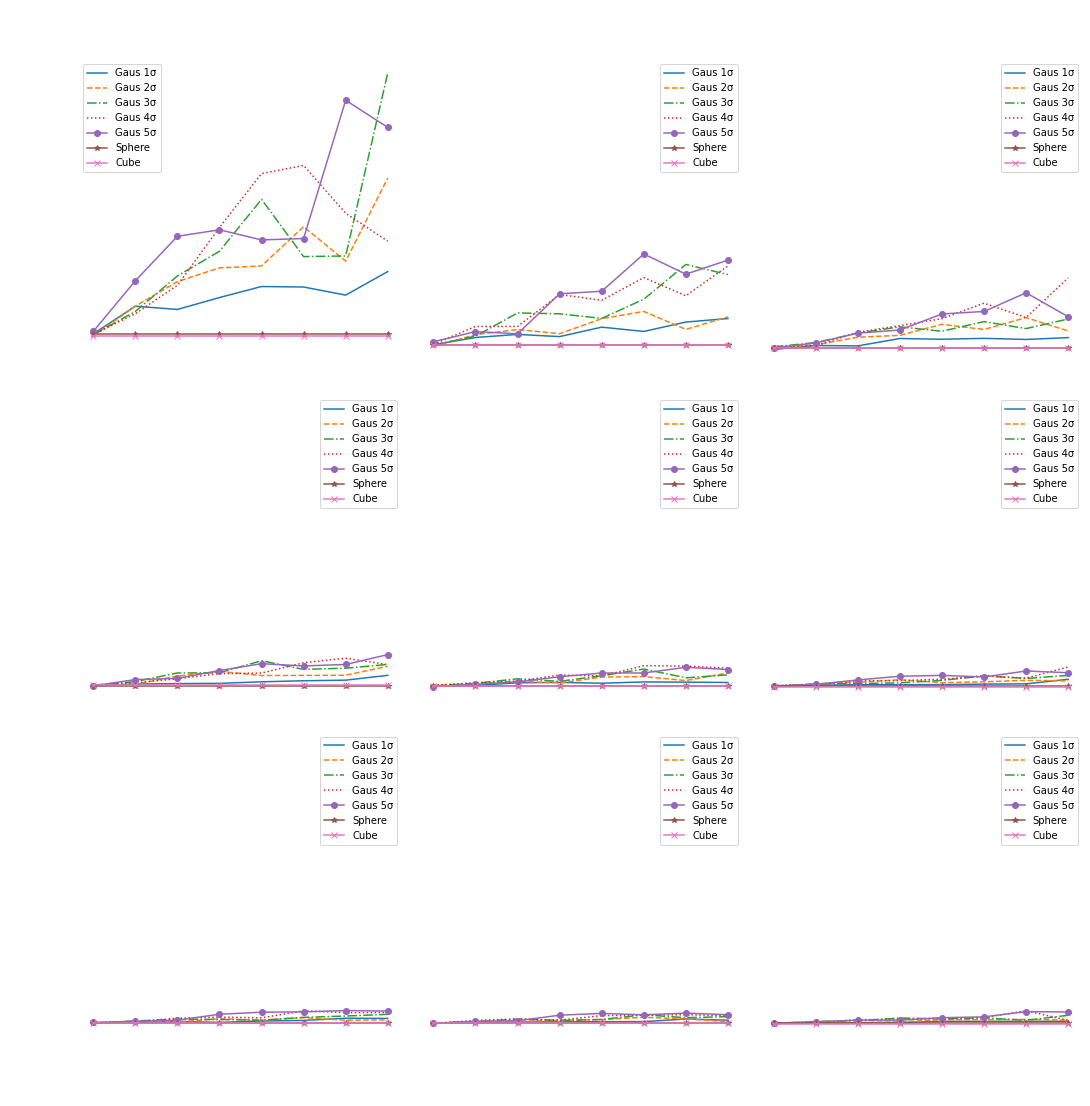

In [308]:
titles = []
for radius in radii:
    titles = np.append(titles, f'Radius = {radius}')
plots(
    x_vals=shell_numbers, 
    y1s=tuple(stand_devs_gaussian[:,:,0]),
    y2s=tuple(stand_devs_gaussian[:,:,1]),
    y3s=tuple(stand_devs_gaussian[:,:,2]),
    y4s=tuple(stand_devs_gaussian[:,:,3]),
    y5s=tuple(stand_devs_gaussian[:,:,4]),
    y6s=tuple(stand_devs_sphere), 
    y7s=tuple(stand_devs_cube),
    y1s_label='Gaus 1σ',
    y2s_label='Gaus 2σ',
    y3s_label='Gaus 3σ',
    y4s_label='Gaus 4σ',
    y5s_label='Gaus 5σ',
    y6s_label='Sphere', 
    y7s_label='Cube',
    y_shared_label='Standard Deviation', 
    x_shared_label='Number of Weighted Bins / Spherical Shells', 
    figure_shape=(3,3), 
    figure_size=(18,18), 
    title=titles, 
    shared_title='Standard Deviation of Average Neutral Fraction Distribution',
    vertical_gap=0.1
)